In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [78]:
df = pd.read_csv('Intermediate_data/baseline_v1.csv',index_col=0)

In [79]:
X_train = df.loc['2000-01-01':'2016-12-31',:].drop('Signal',axis=1)
y_train = df.loc['2000-01-01':'2016-12-31','Signal']
X_test = df.loc['2016-12-31':,:].drop('Signal',axis=1)
y_test = df.loc['2016-12-31':,'Signal']

In [74]:
model = xgb.XGBClassifier(objective='multi:softmax')

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [75]:
accuracy_score(best_model.predict(X_test),y_test)

0.4942528735632184

In [76]:
best_model.predict(X_test)

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],
      dtype=int32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

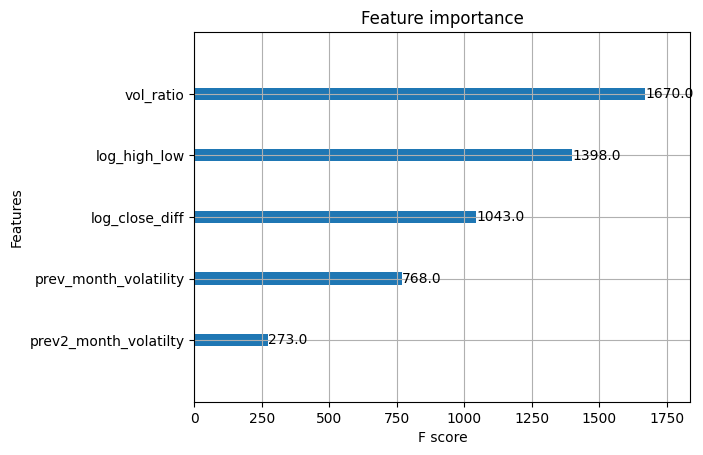

In [77]:
xgb.plot_importance(best_model)

In [81]:
best_model.save_model('Models/baseline_xgboost.bin')

/Users/jadonng/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:21:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [85]:
import pickle

model_path = 'Models/baseline_xgboost.pkl'

# Save the model using pickle
with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

In [86]:
# Load the model using pickle
with open(model_path, 'rb') as file:
    model = pickle.load(file)

In [87]:
model.predict(X_test)

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],
      dtype=int32)